In [ ]:
# ANLY 590 Project 
# Part 3
# JM 
# This notebook uses cnn to predict 2 classes of Pokemon based on their color
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
init_notebook_mode(connected=True)
from google.colab import drive
import re
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
from shutil import copyfile, copy2
from keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.preprocessing import image 

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Pokemon/Pokemon/

/content/drive/My Drive/Pokemon/Pokemon


In [ ]:
pokemons = pd.read_csv('pokemon-images-and-types/pokemon.csv')
numbers = []
for i in range(1,pokemons.shape[0]+1):
    numbers.append(i)
pokemons['pkn'] = numbers
IMG_DIR = 'pokemon-images-dataset/pokemon'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]

In [ ]:
dataframe_img = pd.DataFrame([])
images = []
pokemon_number = []
for img in onlyfiles:
    if not re.search('-', img):
        pkn = img.split('.')
        n = re.sub("[^0-9]", "", pkn[0])
        path = IMG_DIR +'/' +str(img)
        images.append(path)
        pokemon_number.append(n)
dataframe_img['images'] = images
dataframe_img['pkn'] = pokemon_number
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)
result = pokemons.merge(dataframe_img, left_on='pkn', right_on='pkn')
result.head()

,Name,Type1,Type2,pkn,images
0,bulbasaur,Grass,Poison,1,pokemon-images-dataset/pokemon/1.png
1,ivysaur,Grass,Poison,2,pokemon-images-dataset/pokemon/2.png
2,venusaur,Grass,Poison,3,pokemon-images-dataset/pokemon/3.png
3,charmander,Fire,NaN,4,pokemon-images-dataset/pokemon/4.png
4,charmeleon,Fire,NaN,5,pokemon-images-dataset/pokemon/5.png


In [ ]:
# We will be focusing on water and fire
select = ['Water', 'Fire']
result = result[result['Type1'].isin(select)]

In [ ]:
# train, test, validation split

X_train, X_test, y_train, y_test = train_test_split(
    result, result['Type1'],test_size = 0.4, random_state=919)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size = 0.5, random_state = 919)

In [ ]:
datagen = image.ImageDataGenerator()
trainDf = pd.DataFrame(X_train) 
trainDf["Type1"] = y_train 
train = datagen.flow_from_dataframe(trainDf, x_col = "images", y_col = "Type1") 

Found 90 validated image filenames belonging to 2 classes.


In [ ]:
testDf = pd.DataFrame(X_test) 
testDf["Type1"] = y_test 
test = datagen.flow_from_dataframe(testDf, x_col = "images", y_col = "Type1") 

Found 30 validated image filenames belonging to 2 classes.


In [ ]:
valDf = pd.DataFrame(X_val) 
valDf["Type1"] = y_val 
val = datagen.flow_from_dataframe(valDf, x_col = "images", y_col = "Type1") 

Found 30 validated image filenames belonging to 2 classes.


In [ ]:
# CNN model for 3 classes
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
def cnn_model_2():
    model = Sequential()
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3
    model.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    model.summary()
    return model
model = cnn_model_2()
model.summary()
history = model.fit_generator(train, epochs=50, validation_data=val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 255, 255, 32)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        2

In [ ]:
predict = model.predict_generator(test)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'
fig = go.Figure()
epochs = []
for i in range(len(history.history['acc'])):
    epochs.append(i)
fig.add_trace(go.Scatter(x=epochs,y=history.history['acc'], mode='lines',name='Training Accuracy'))
fig.add_trace(go.Scatter(x=epochs,y=history.history['val_acc'], mode='lines',name='Validation Accuracy'))
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'width': 500, 
        'height': 400

})
fig.show()

In [ ]:
from sklearn.metrics import classification_report
predict_frame = pd.DataFrame([])
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category']))

              precision    recall  f1-score   support

        Fire       0.17      0.14      0.15         7
       Water       0.75      0.78      0.77        23

    accuracy                           0.63        30
   macro avg       0.46      0.46      0.46        30
weighted avg       0.61      0.63      0.62        30



In [ ]:
def show_wrong_classification(y_test, predict, result):
    tmp = result[result.index.isin(y_test.index)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    i=0
    for imag, true, pred in zip(tmp['images'], tmp['Type1'], predict):
        if true!=pred:
            if i <3:
                img = Image.open(imag)
                fig = plt.figure()
                ax[i].imshow(img)
                ax[i].set_title(str(pred))
                i+=1

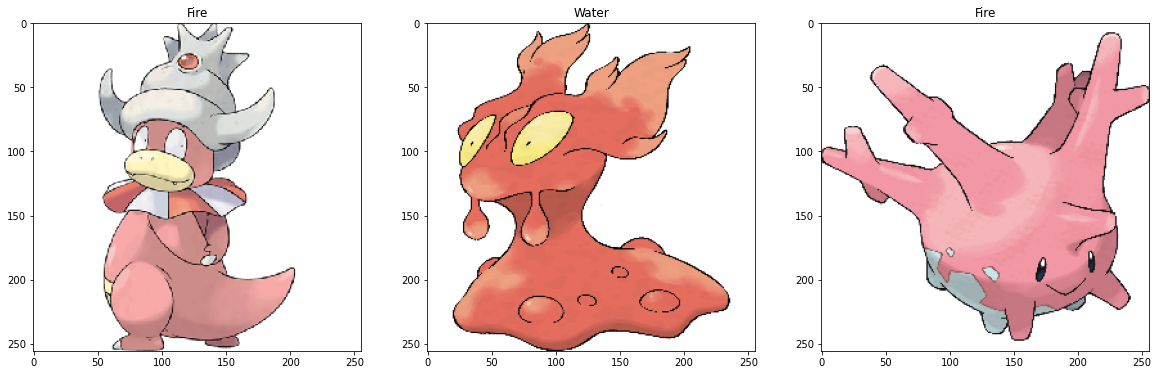

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
from PIL import Image
show_wrong_classification(y_test, predict_frame['category'], result)